This jupyter notebook fits smaller HMMs per subejct as a test, then finds the best pooled model across all 84 subjects--iterating through 1-3 states and 0 to 10 random init numbers.

In [1]:
import numpy as np
import pandas as pd
import json
from hmmlearn import hmm
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import arviz
import pickle
from scipy import stats
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
print("Loading data...")
with open("../cleaned_data_files/subject_data_for_HMM.json", "r") as f:
    subject_data = json.load(f)
    
print(f"Loaded {len(subject_data)} subjects")

Loading data...
Loaded 84 subjects


# test first with individual subjects:

In [3]:
# Test with first few subjects
test_subjects = list(subject_data.keys())[:5]

Fit individual subjects first:

In [4]:
for subject_id in test_subjects:
    print(f"\n--- Subject {subject_id} ---")
    
    subj = subject_data[subject_id]
    
    # Prepare observations
    accuracy = np.array(subj['epoch_accuracy'])
    rest_duration = np.array(subj['post_epoch_post_cue_rest_duration'])
    # rest_follows_switch_cue = np.array(subj['rest_cue_type']) # 1 is switch 0 is stay
    # acc_follows_switch = np.array(subj['epoch_follows_task_switch']) # 1 is switch 0 is stay
    # overall_epoch = np.array(subj['overall_epoch']) # 1 to 30
    # game_type = np.array(subj['game_type']) # spatial_recall or digit_span
    
    # create observation array
    obs = np.column_stack([accuracy, rest_duration])
    
    print(f"Observation data shape: {obs.shape}")
    print(f"Accuracy range: {accuracy.min():.3f} to {accuracy.max():.3f}")
    print(f"Rest range: {rest_duration.min():.3f} to {rest_duration.max():.3f} trials")

    # PER SUBJECT: fit 10 different models (with 10 different random initializations) and pick the best ones
    # also try different states (from 1 to 3)
    scores = list()
    models = list()
    for n_components in range(1, 3):
        for idx in range(10):  # ten different random starting states
            # define our hidden Markov model
            model = hmm.GaussianHMM(n_components=n_components, covariance_type="full", 
                               n_iter=50, random_state=idx)
            model.fit(obs)
            models.append(model)
            scores.append(model.score(obs))
            print(f'Converged: {model.monitor_.converged}\t\t'
                  f'Score: {scores[-1]}')
    
    # get the best model
    model = models[np.argmax(scores)]
    print(f'The best model for subject {subject_id} had a score of {max(scores)} and '
          f'{model.n_components} components')

    # print results
    log_prob = model.score(obs)
    states = model.predict(obs)
    print(f"✓ Model fitted successfully!")
    print(f"  bed model log probability: {log_prob:.2f}")
    print(f"  Converged: {model.monitor_.converged}")

    # Show state characteristics
    print("\nState characteristics:")
    for i in range(model.n_components):
        mean_acc = model.means_[i, 0]
        mean_rest = model.means_[i, 1]
        state_count = np.sum(states == i)
        print(f"  State {i}: accuracy={mean_acc:.3f}, rest={mean_rest:.3f}s, count={state_count}")

    print(f"\nTransition matrix for subject {subject_id}:")
    for i, row in enumerate(model.transmat_):
        print(f"  From state {i}: {row}")


--- Subject 4 ---
Observation data shape: (30, 2)
Accuracy range: 0.700 to 1.000
Rest range: 1.000 to 9.000 trials
Converged: True		Score: -43.63289495431464
Converged: True		Score: -43.63289495431464
Converged: True		Score: -43.63289495431464
Converged: True		Score: -43.63289495431464
Converged: True		Score: -43.63289495431464
Converged: True		Score: -43.63289495431464
Converged: True		Score: -43.63289495431464
Converged: True		Score: -43.63289495431464


Model is not converging.  Current: -30.629933355565075 is not greater than -30.62966587766252. Delta is -0.00026747790255399195


Converged: True		Score: -43.63289495431464
Converged: True		Score: -43.63289495431464
Converged: True		Score: -19.342622699569024
Converged: True		Score: -19.335482969377583
Converged: True		Score: -18.406738186001096
Converged: True		Score: -30.63004812216988
Converged: True		Score: -19.33548784995976
Converged: True		Score: -18.406767676441593
Converged: True		Score: -18.406726272811557
Converged: True		Score: -19.336094088233025
Converged: True		Score: -19.33962817548624
Converged: True		Score: -40.71457518954646
The best model for subject 4 had a score of -18.406726272811557 and 2 components
✓ Model fitted successfully!
  bed model log probability: -18.41
  Converged: True

State characteristics:
  State 0: accuracy=0.927, rest=1.411s, count=22
  State 1: accuracy=0.900, rest=6.320s, count=8

Transition matrix for subject 4:
  From state 0: [0.66146954 0.33853046]
  From state 1: [9.99998359e-01 1.64080783e-06]

--- Subject 5 ---
Observation data shape: (30, 2)
Accuracy range: 0.30

# Run pooled across all subjects

Pooled model with all test subjects:

In [5]:
test_subjects = list(subject_data.keys())#all subjects

In [6]:
# Combine all subjects
all_obs = []
lengths = []

for subject_id in test_subjects:
    subj = subject_data[subject_id]
    accuracy = np.array(subj['epoch_accuracy'])
    rest_duration = np.array(subj['post_epoch_post_cue_rest_duration'])
    obs = np.column_stack([accuracy, rest_duration])
    all_obs.append(obs)
    lengths.append(len(obs))

pooled_obs = np.vstack(all_obs)
print(f"Pooled data shape: {pooled_obs.shape}")
print(f"Subject lengths: {lengths}")

pooled_obs[:, 1] = pooled_obs[:, 1] / 20  # Scale rest to 0-1 range
print(f"Pooled data shape: {pooled_obs.shape}")
print(f"Subject lengths: {lengths}")

scores = list()
models = list()
for n_components in range(1, 4):
    for idx in range(10):
        print(f"doing component: {n_components}, random state: {idx}")
        pooled_model = hmm.GaussianHMM(n_components=n_components, covariance_type="full",
                                      n_iter=50, random_state=idx)
        pooled_model.fit(pooled_obs, lengths=lengths)
        models.append(pooled_model)
        scores.append(pooled_model.score(pooled_obs, lengths=lengths))
        print(f'Converged: {pooled_model.monitor_.converged}\t\t'
              f'Score: {scores[-1]}')

Pooled data shape: (2520, 2)
Subject lengths: [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]
Pooled data shape: (2520, 2)
Subject lengths: [30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]
doing component: 1, random state: 0
Converged: True		Score: -1801.4423572556432
doing component: 1, random state: 1
Converged: True		Score: -1801.4423572556432
doing component: 1, random state: 2
Converged: True		Score: -1801.44235725

Model is not converging.  Current: 1881.542331345662 is not greater than 1881.5521771075232. Delta is -0.009845761861242863


Converged: True		Score: 1881.5337218969003
doing component: 3, random state: 7
Converged: True		Score: 3064.944127552998
doing component: 3, random state: 8
Converged: True		Score: 1389.0535052794335
doing component: 3, random state: 9
Converged: True		Score: 3064.9441081477557


In [7]:
# get the best model
pooled_model = models[np.argmax(scores)]
print(f'The best model had a score of {max(scores)} and '
      f'{pooled_model.n_components} components')
pooled_log_prob = pooled_model.score(pooled_obs, lengths=lengths)
print(f"✓ Pooled model fitted successfully!")
print(f"  Log probability: {pooled_log_prob:.2f}")
print(f"  Converged: {pooled_model.monitor_.converged}")

print(f"\nPooled state characteristics:")
for i in range(pooled_model.n_components):
    mean_acc = pooled_model.means_[i, 0]
    mean_rest = pooled_model.means_[i, 1] * 20  # Convert back to original scale
    print(f"  State {i}: accuracy={mean_acc:.3f}, rest={mean_rest:.1f} trials")

print(f"\nPooled transition matrix:")
for i, row in enumerate(pooled_model.transmat_):
    print(f"  From state {i}: {row}")

The best model had a score of 3357.698192540759 and 3 components
✓ Pooled model fitted successfully!
  Log probability: 3357.70
  Converged: True

Pooled state characteristics:
  State 0: accuracy=0.670, rest=6.4 trials
  State 1: accuracy=0.913, rest=1.2 trials
  State 2: accuracy=0.657, rest=20.0 trials

Pooled transition matrix:
  From state 0: [0.77027135 0.14646854 0.08326011]
  From state 1: [0.17359728 0.79466939 0.03173332]
  From state 2: [0.17635866 0.03475062 0.78889072]


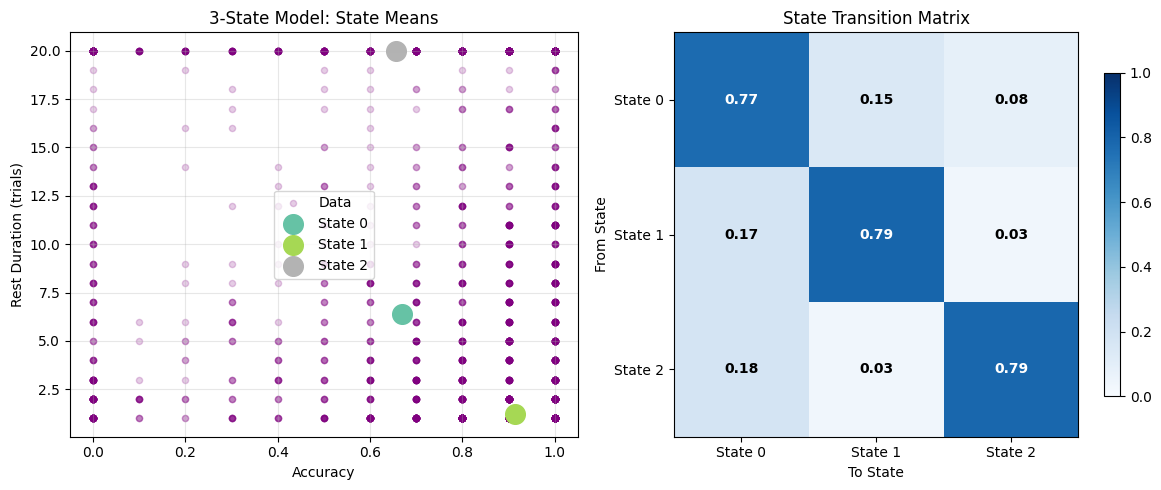

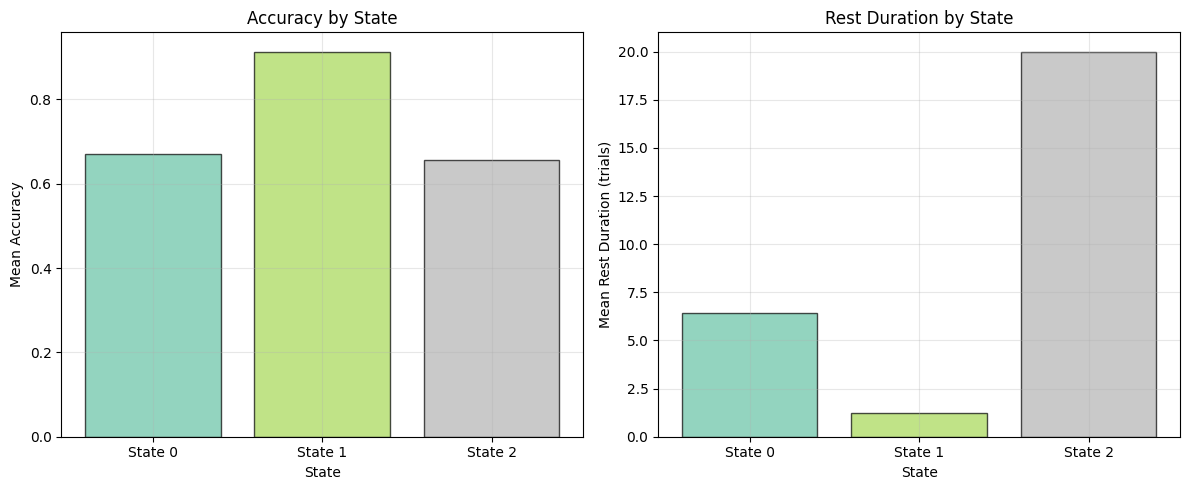

In [8]:
# visualization
n_states = pooled_model.n_components
    
if n_states == 1:
    # Single state
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    # Plot data points
    ax.scatter(pooled_obs[:, 0], pooled_obs[:, 1] * 20, alpha=0.3, c='gray', s=20, label='Data')
    
    # Plot state mean
    mean_acc = pooled_model.means_[0, 0]
    mean_rest = pooled_model.means_[0, 1] * 20
    ax.scatter(mean_acc, mean_rest, s=300, c='red', marker='x', 
              linewidths=3, label='State Mean')
    
    ax.set_xlabel('Accuracy')
    ax.set_ylabel('Rest Duration (trials)')
    ax.set_title('Single State Model')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
else:
    # Multiple states
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: State means
    colors = plt.cm.Set2(np.linspace(0, 1, n_states))  # Generate colors for any number of states
    
    # Plot points
    axes[0].scatter(pooled_obs[:, 0], pooled_obs[:, 1] * 20, alpha=0.2, c='purple', s=20, label='Data')
    
    # Plot means
    for i in range(n_states):
        mean_acc = pooled_model.means_[i, 0]
        mean_rest = pooled_model.means_[i, 1] * 20  # Convert to original scale (trials)
        axes[0].scatter(mean_acc, mean_rest, s=200, alpha=1, 
                      c=[colors[i]], label=f'State {i}')
    
    axes[0].set_xlabel('Accuracy')
    axes[0].set_ylabel('Rest Duration (trials)')
    axes[0].set_title(f'{n_states}-State Model: State Means')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Transition matrix
    im = axes[1].imshow(pooled_model.transmat_, cmap='Blues', vmin=0, vmax=1)
    axes[1].set_title('State Transition Matrix')
    axes[1].set_xlabel('To State')
    axes[1].set_ylabel('From State')
    
    # Add colorbar
    plt.colorbar(im, ax=axes[1], shrink=0.8)
    
    # Add text annotations for all states
    for i in range(n_states):
        for j in range(n_states):
            text_color = 'white' if pooled_model.transmat_[i,j] > 0.5 else 'black'
            axes[1].text(j, i, f'{pooled_model.transmat_[i,j]:.2f}', 
                       ha='center', va='center', color=text_color, fontweight='bold')
    
    # Set tick labels
    axes[1].set_xticks(range(n_states))
    axes[1].set_yticks(range(n_states))
    axes[1].set_xticklabels([f'State {i}' for i in range(n_states)])
    axes[1].set_yticklabels([f'State {i}' for i in range(n_states)])

plt.tight_layout()
plt.show()

# Additional plot where it shows rest and acc separately by state
if n_states >= 3:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Accuracy by state
    accs = [pooled_model.means_[i, 0] for i in range(n_states)]
    axes[0].bar(range(n_states), accs, color=colors, alpha=0.7, edgecolor='black')
    axes[0].set_xlabel('State')
    axes[0].set_ylabel('Mean Accuracy')
    axes[0].set_title('Accuracy by State')
    axes[0].set_xticks(range(n_states))
    axes[0].set_xticklabels([f'State {i}' for i in range(n_states)])
    axes[0].grid(True, alpha=0.3)
    
    # Rest duration by state
    rests = [pooled_model.means_[i, 1] * 20 for i in range(n_states)]
    axes[1].bar(range(n_states), rests, color=colors, alpha=0.7, edgecolor='black')
    axes[1].set_xlabel('State')
    axes[1].set_ylabel('Mean Rest Duration (trials)')
    axes[1].set_title('Rest Duration by State')
    axes[1].set_xticks(range(n_states))
    axes[1].set_xticklabels([f'State {i}' for i in range(n_states)])
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [10]:
# save the best pooled model:
model_package = {
    'model': pooled_model, # The actual model
    'performance': {
        'log_likelihood': max(scores),
        'converged': pooled_model.monitor_.converged,
        'all_scores': scores
    },
    'data_context': {
        'rest_scaling_factor': 20,
        'n_subjects': len(test_subjects),
        'subject_lengths': lengths,
        'subjects_used': test_subjects,
        'total_observations': len(pooled_obs)
    },
    'model_info': {
        'n_components': pooled_model.n_components,
        'covariance_type': 'full',
        'date_created': str(datetime.now()),
        'notes': '3-state model: Focused -> Intermediate -> Fatigue'
    }
}

with open('pooled_models/complete_best_pooled_hmm_analysis.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("Model saved successfully!")

Model saved successfully!
